# Neural Nets with Keras

## TODO

- Implement lr_range with early stopping when val_loss diverges
- Implement lr_range plot
- Find out which optimizer fastai uses for lr_range plot

- Implement one-cycle schedule callback

# Imports

In [1]:
# Workaround for making pydot work in current env
import os
PATH = os.getenv('PATH')
%env PATH=/Users/anto/miniconda3/envs/fastai/bin:$PATH

env: PATH=/Users/anto/miniconda3/envs/fastai/bin:/Users/anto/miniconda3/bin:/Users/anto/exec -l /bin/bash/google-cloud-sdk/bin:/Users/anto/miniconda3/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/X11/bin:/usr/local/git/bin


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time
from functools import partial
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keract

Using TensorFlow backend.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras, keract:
    print(module.__name__, module.__version__)

python 3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf
keract 2.5.1


In [4]:
assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [28]:
#plt.rcParams['figure.dpi']

72.0

In [17]:
#%matplotlib notebook

In [19]:
#plt.rcParams['figure.dpi'] = 72

# Functions

In [6]:
import tensorflow.keras.backend as K

class LearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler.
    # Arguments
        schedule: a function that takes an epoch index as input
            (integer, indexed from 0) and current learning rate
            and returns a new learning rate as output (float).
        verbose: int. 0: quiet, 1: update messages.
    """

    def __init__(self, schedule, verbose=0, divergence=5):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.verbose = verbose
        self.best_loss = np.inf
        self.loss = []
        self.lr = []
        self.divergence = divergence

    def on_train_batch_begin(self, batch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(K.get_value(self.model.optimizer.lr))
        lr = self.schedule(batch, lr)
        if not isinstance(lr, (float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: LearningRateScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_train_batch_end(self, batch, logs=None):
        #print(f'\ntrain batch end {batch}.')
        self.lr.append(K.get_value(self.model.optimizer.lr))
        current_loss = logs['loss']
        self.loss.append(current_loss)
        if current_loss > self.divergence*self.best_loss:
            print(f'\nbatch {batch}. current loss = {current_loss} best_loss = {self.best_loss}')
            self.model.stop_training = True
        if current_loss < self.best_loss:
            self.best_loss = current_loss

    def on_epoch_end(self, epoch, logs=None):
        print(f'\nEnd of epoch {epoch}, logs: {logs}')
        #logs = logs or {}
        #logs['lr'] = K.get_value(self.model.optimizer.lr)
        #self.model.stop_training = True

# Plot functions

In [7]:
def _default(def_dict, user_dict):
    if user_dict is None:
        user_dict = {}
    return {**def_dict, **user_dict}

def plot_learning_curves(history, title=None, axes=None, plot_kw=None):
    # This plot accepts both an History obj or
    # a dict like History.history
    if hasattr(history, 'history'):
        history = history.history
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    else:
        assert len(axes) == 2
        fig = axes[0].figure
    df = pd.DataFrame(history)
    plot_kw = _default(dict(marker='o', ms='4'), plot_kw)
    df[['loss', 'val_loss']].plot(ax=axes[0], **plot_kw)
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], **plot_kw)
    for ax in axes:
        ax.grid(True)
        ax.set_xlabel('Epochs')
        ax.set_xlim(-0.25, df.shape[0] - 0.75)
    y_th = 0.6
    frac = 0.3
    ymin = y_th if (df.accuracy > y_th).sum() > frac*df.shape[0] else 0
    axes[1].set_ylim(ymin, 1);
    axes[0].set_title('Loss')
    axes[1].set_title(f'Accuracy, max(val_acc) = {df.val_accuracy.max():.3f} @ {df.val_accuracy.idxmax()}')
    axes[1].axvline(df.val_accuracy.idxmax(), color='k', ls='--')
    if title is not None:
        fig.suptitle(title)
        
def plot_weights(history, axes=None, hist_kw=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    else:
        assert len(axes) == 2
        fig = axes[0].figure
    model = history.model
    hist_kw = _default(dict(bins=80, histtype='step', density=True), hist_kw)
    for la in model.layers:
        params = la.get_weights()
        if len(params) == 1:
            w, b = params[0], np.array([])
        elif len(params) == 2:
            w, b = params
        else:
            continue
        axes[0].hist(w.ravel(), label=la.name, **hist_kw);
        axes[1].hist(b.ravel(), label=la.name, **hist_kw);
    axes[1].legend();
    axes[0].set_xlabel('weights')
    axes[1].set_xlabel('bias')
    for ax in axes: ax.grid(True)

# Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [9]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

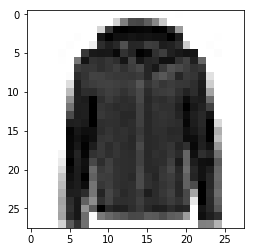

In [10]:
plt.imshow(X_train[0], cmap="binary");

The labels are the class IDs (represented as uint8), from 0 to 9:

In [11]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [13]:
X_valid.shape

(5000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled.shape, X_test_scaled.dtype

((10000, 28, 28), dtype('float32'))

# Build a classification neural network with Keras

In [16]:
def lr_range(batch, lr, init_lr=1e-4, points_per_dec=2):
    if batch == 0:
        return init_lr
    factor = 10**(1/points_per_dec)
    return lr * factor

In [158]:
kernel_init = "he_normal"
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="selu", kernel_initializer=kernel_init),
    #keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="selu", kernel_initializer=kernel_init),
    #keras.layers.BatchNormalization(),
#    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax", 
                       kernel_initializer='glorot_uniform'),
    ],)
optim = keras.optimizers.Nadam()
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    LearningRateScheduler(partial(lr_range, init_lr=1e-4, points_per_dec=3)),
]

batch_size = 256
epochs = 4
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/4
 2304/55000 [>.............................] - ETA: 7s - loss: 4.0654 - accuracy: 0.2248  
batch 9. current loss = 22.623397827148438 best_loss = 2.0341591835021973

End of epoch 0, logs: {'loss': 5.921192383766174, 'accuracy': 0.22773437}


In [159]:
history.history

{'loss': [5.921192383766174], 'accuracy': [0.22773437]}

In [160]:
callbacks[0].lr

[1e-04,
 0.00021544346,
 0.00046415886,
 0.0009999999,
 0.0021544346,
 0.004641589,
 0.01,
 0.021544347,
 0.046415888,
 0.1]

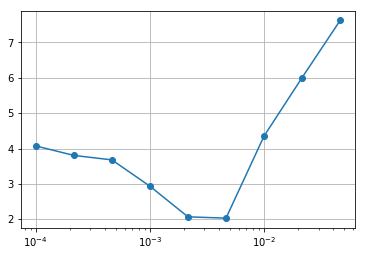

In [161]:
n = -1
plt.plot(callbacks[0].lr[:-1], callbacks[0].loss[:-1], '-o')
plt.xscale('log')
#plt.yscale('log')
plt.grid(True)

In [162]:
kernel_init = "he_normal"
batch_size = 256
epochs = 10
lr = 1e-3
activation="selu"
#α_reg = 1e-4
#mom = 0.8
nesterov = True
model_name = (f'NAdam(lr={lr:.1g}) (100, 50, 10), scaled input, '
              f'batch_size = {batch_size}, {kernel_init}, {activation} '
              #f'α_reg = {α_reg:.1g} N_mom = {mom:.1g}'
             )
HiddenDense = partial(keras.layers.Dense,
                      activation=activation, 
                      kernel_initializer=kernel_init,
                      #kernel_regularizer=keras.regularizers.l2(α_reg)
                     )
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    HiddenDense(100),
    #keras.layers.AlphaDropout(rate=0.2),
    #keras.layers.BatchNormalization(),
    HiddenDense(50),
    #keras.layers.AlphaDropout(rate=0.2),
    #keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax", 
                       kernel_initializer='glorot_uniform',
                       ),
    ],
    name=model_name)
optim = keras.optimizers.Nadam(lr)
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model_name)
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid))

NAdam(lr=0.001) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu 
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.5870 - accuracy: 0.7932 - val_loss: 0.4298 - val_accuracy: 0.8462
Epoch 2/10
55000/55000 [==============================] - 1s 25us/sample - loss: 0.3946 - accuracy: 0.8578 - val_loss: 0.3627 - val_accuracy: 0.8708
Epoch 3/10
55000/55000 [==============================] - 1s 27us/sample - loss: 0.3535 - accuracy: 0.8731 - val_loss: 0.3621 - val_accuracy: 0.8780
Epoch 4/10
55000/55000 [==============================] - 2s 29us/sample - loss: 0.3288 - accuracy: 0.8793 - val_loss: 0.3299 - val_accuracy: 0.8842
Epoch 5/10
55000/55000 [==============================] - 2s 30us/sample - loss: 0.3043 - accuracy: 0.8885 - val_loss: 0.3315 - val_accuracy: 0.8824
Epoch 6/10
55000/55000 [==============================] - 2s 34us/sample - loss: 0.2846 - accuracy: 0.8948 - val_loss: 0.3279 

Model: "NAdam(lr=0.001) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu "
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_40 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_101 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_102 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


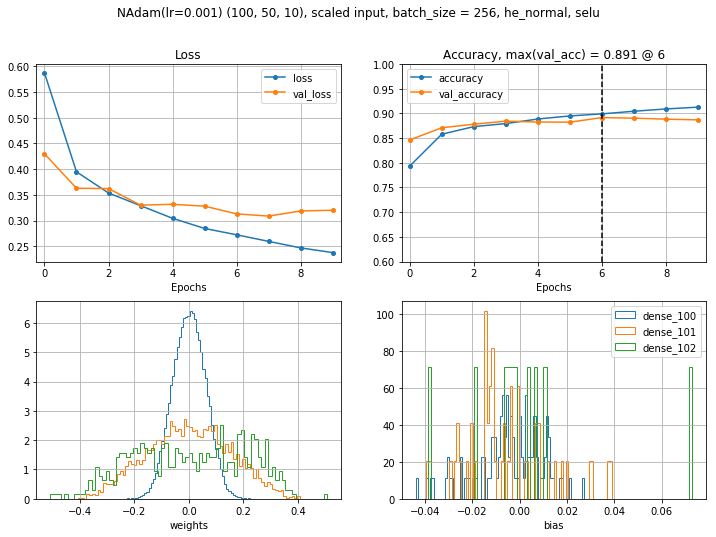

In [163]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "NAdam(lr=0.002) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu "
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_92 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_93 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


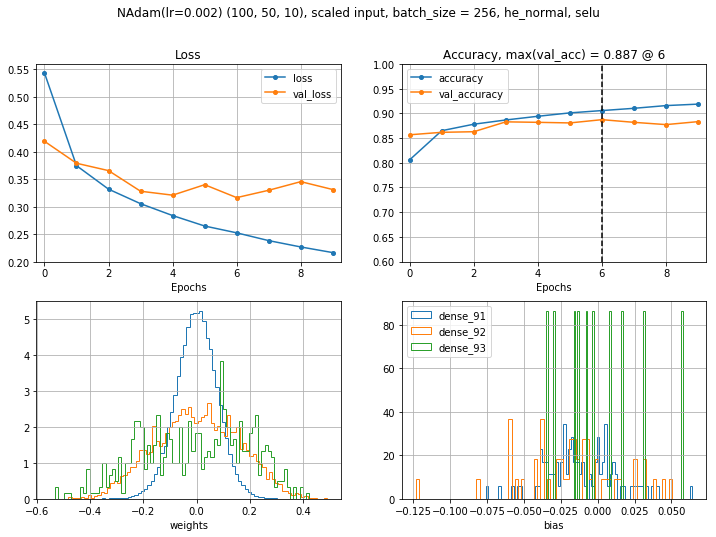

In [156]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu "
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_89 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_90 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


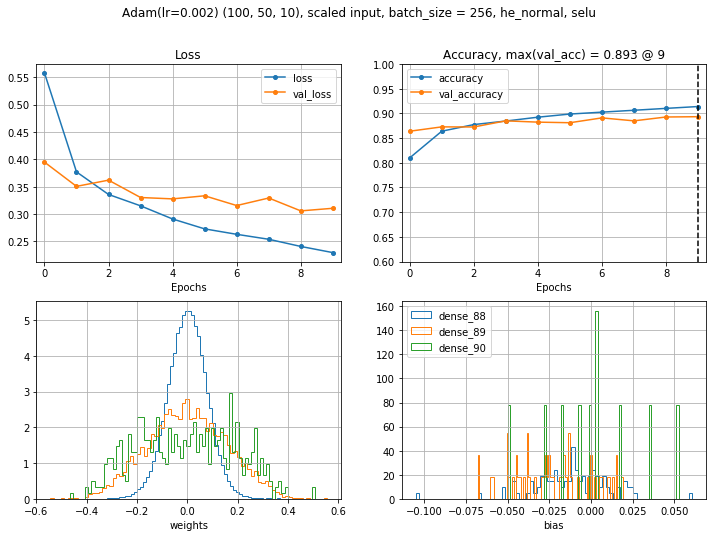

In [154]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, ADO_02, 50, ADO_02, 10), scaled input, batch_size = 256, he_normal, selu "
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 100)               78500     
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 50)                5050      
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 50)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params:

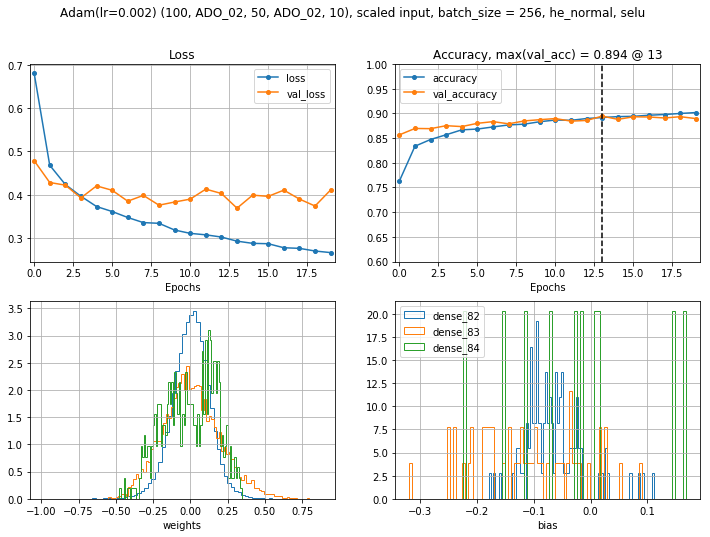

In [149]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu α_reg = 0.0001 N_mom = 0.8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_77 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_78 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


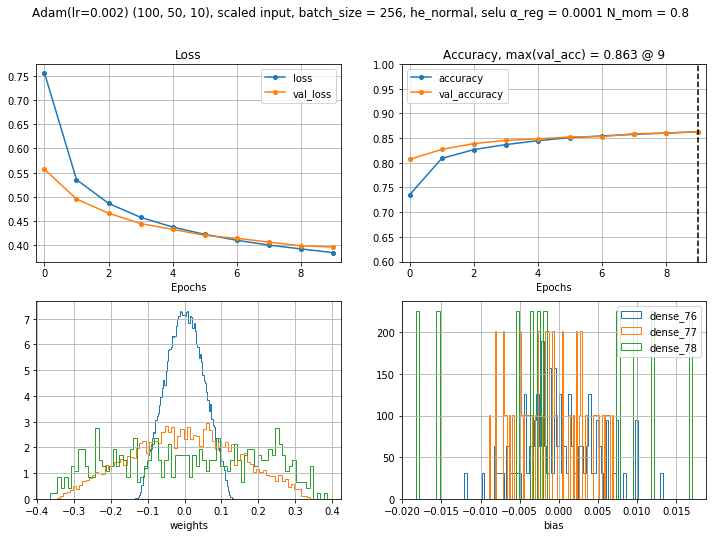

In [137]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu α_reg = 0.001 N_mom = 0.9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_71 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_72 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


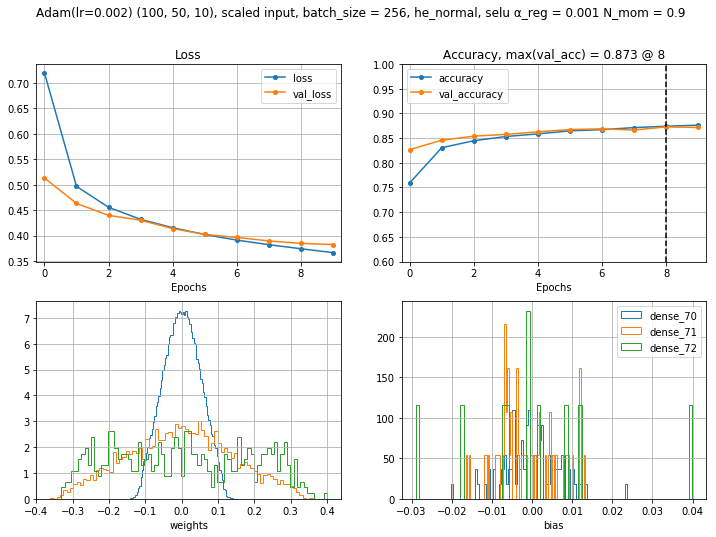

In [134]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu α_reg = 0.001"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_68 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_69 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


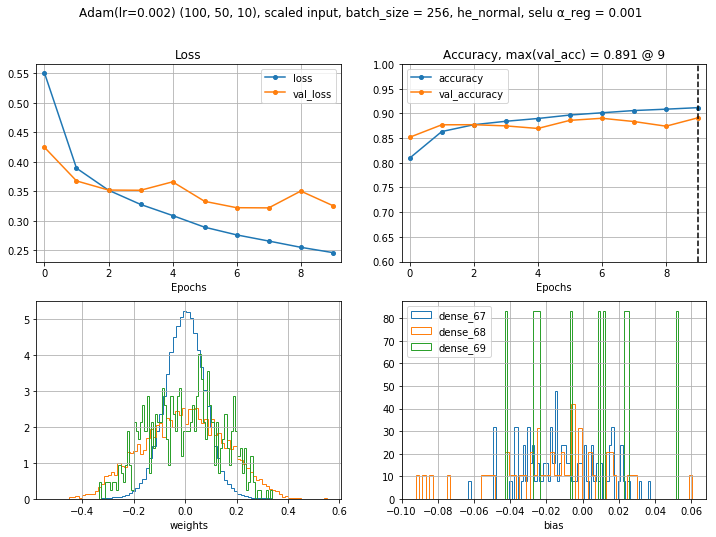

In [132]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_56 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_57 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


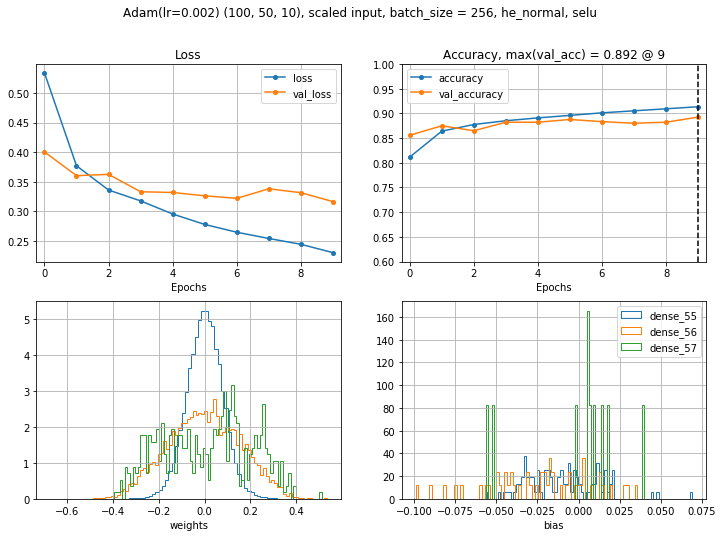

In [124]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, 10), scaled input, batch_size = 256, he_normal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_53 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_54 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


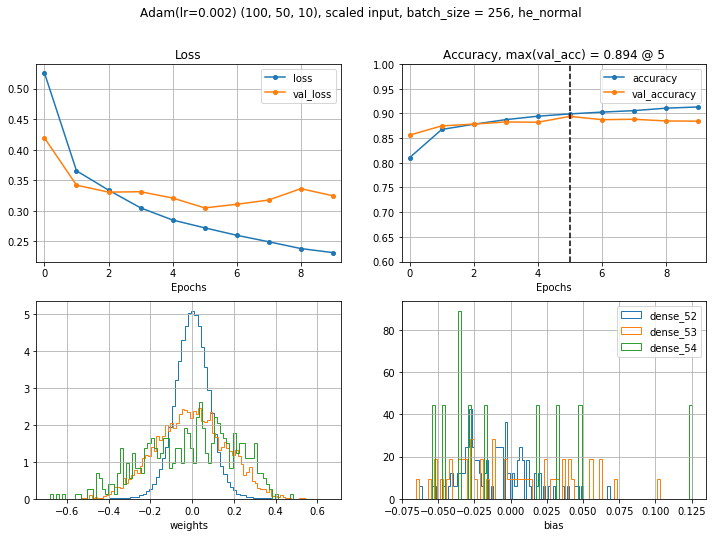

In [122]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.001) (300, BN, 100, BN, 10), scaled input, batch_size = 32, he_normal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 300)               235500    
_________________________________________________________________
batch_normalization_v2_8 (Ba (None, 300)               1200      
_________________________________________________________________
dense_47 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_v2_9 (Ba (None, 100)               400       
_________________________________________________________________
dense_48 (Dense)             (None, 10)                1010      
Total params: 268,210
Trainable params: 267,410
Non-t

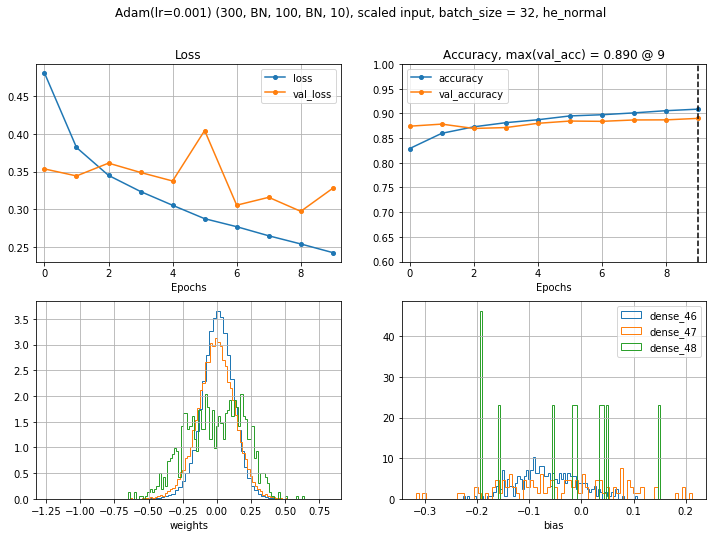

In [119]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, DO_02, 10), scaled input, batch_size = 256, he_normal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 100)               400       
_________________________________________________________________
dense_38 (Dense)             (None, 50)                5050      
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 50)                200       
_________________________________________________________________
dense_39 (Dense)             (None, 10)                510       
Total params: 84,660
Trainable params: 84,360
Non-trai

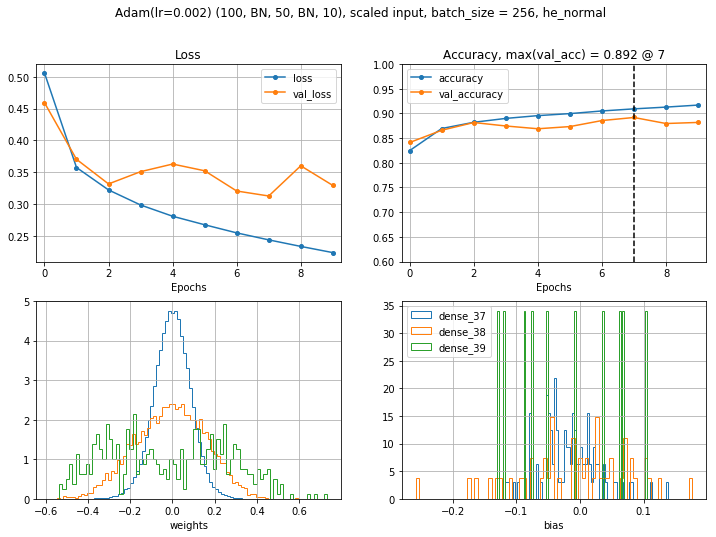

In [111]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, DO_02, 10), scaled input, batch_size = 256, lecun_normal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


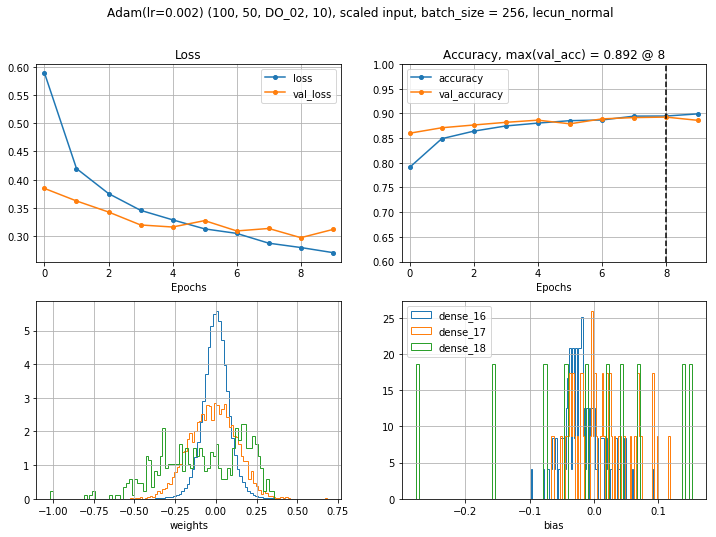

In [89]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, DO_02, 10), scaled input, batch_size = 256, he_normal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


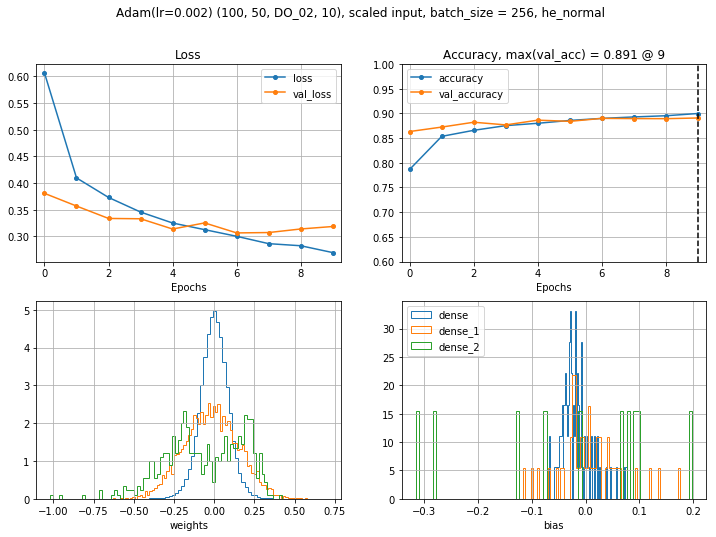

In [18]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "Adam(lr=0.002) (100, 50, DO_02, 10), scaled input, batch_size = 256, he_normal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_50 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_151 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_44 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


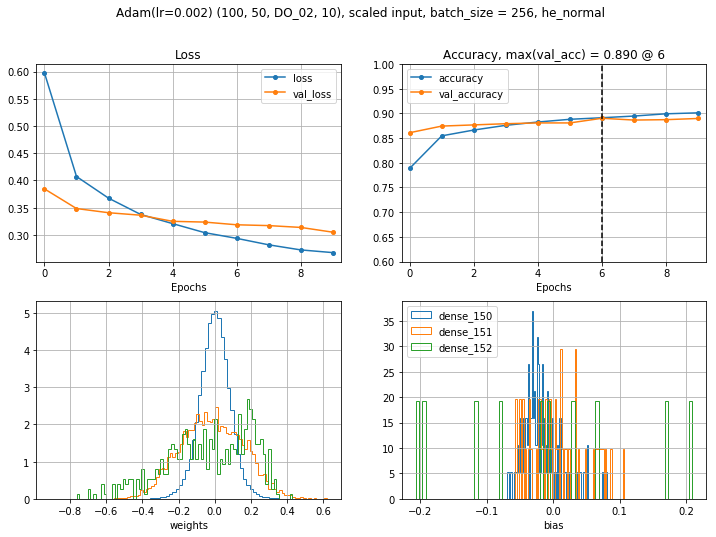

In [175]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_46 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_139 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_42 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


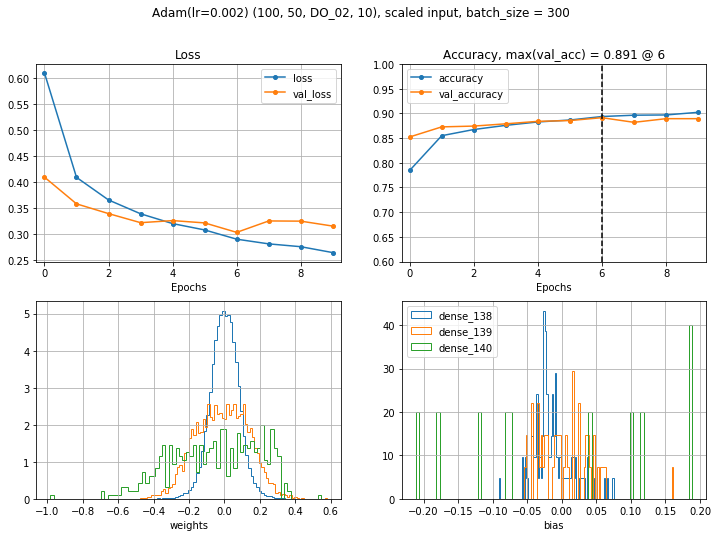

In [165]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr={lr:.1g}) (100, 50, DO_02, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_45 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_136 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


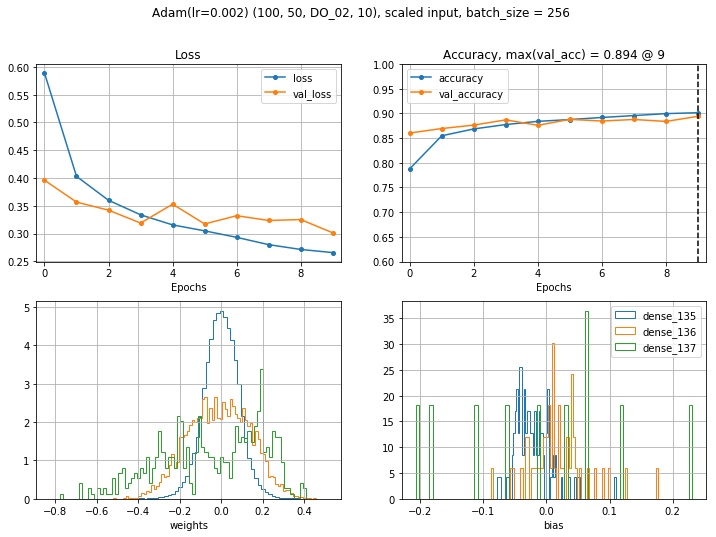

In [163]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr={lr:.1g}) (100, 50, DO_02, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_43 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_130 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_39 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


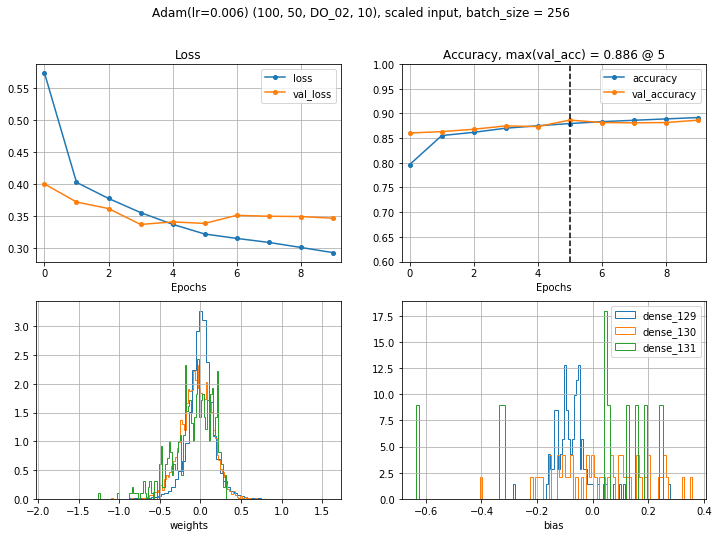

In [159]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr={lr:.1g}) (100, 50, DO_02, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_42 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_127 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


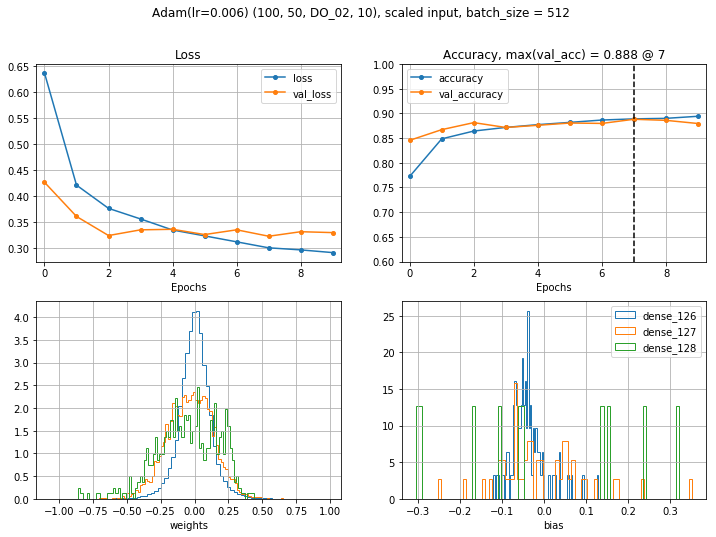

In [157]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr={lr:.1g}) (100, 50, DO_02, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_115 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


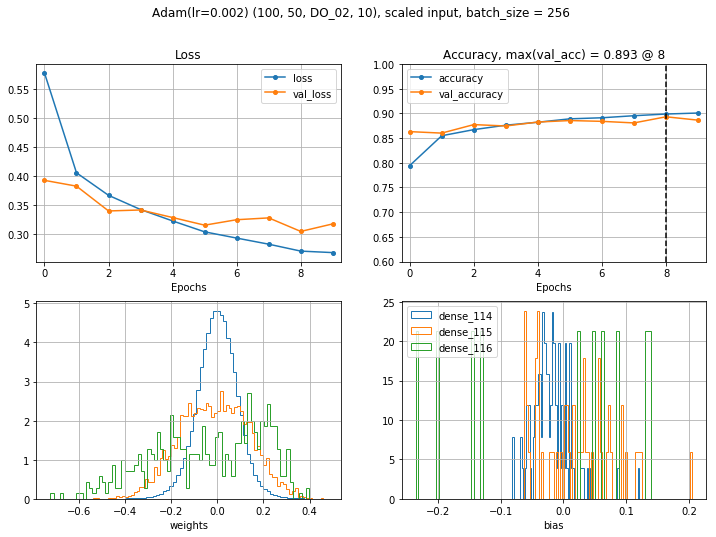

In [149]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr={lr:.1g}) (100, 50, DO_02, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_112 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_33 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


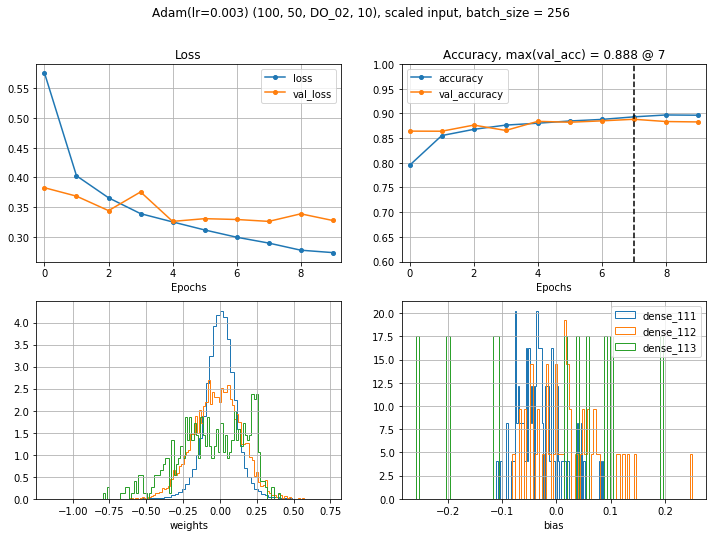

In [146]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr={lr:.1g}) (100, 50, DO_02, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_106 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


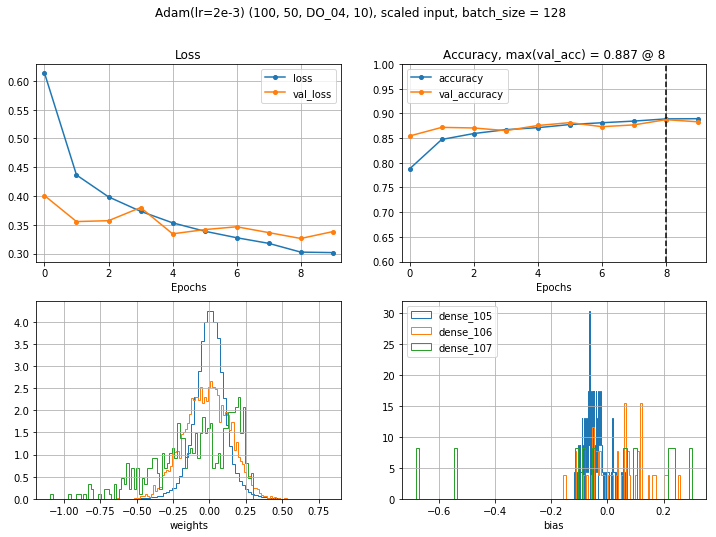

In [140]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr=2e-3) (100, 50, DO_04, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_103 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


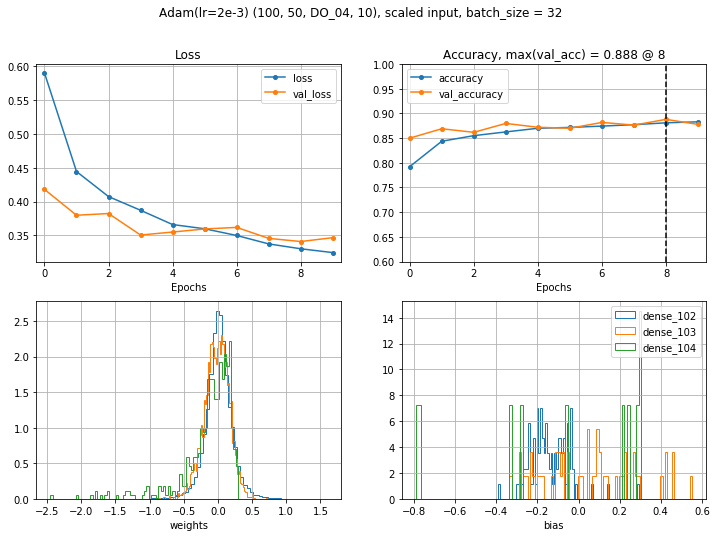

In [138]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle(f'Adam(lr=2e-3) (100, 50, DO_04, 10), scaled input, batch_size = {batch_size}');
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization_v2 (Batc (None, 100)               400       
_________________________________________________________________
dense_100 (Dense)            (None, 50)                5050      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 50)                200       
_________________________________________________________________
dense_101 (Dense)            (None, 10)                510       
Total params: 84,660
Trainable params: 84,360
Non-trainable params: 300
_______________________________________________

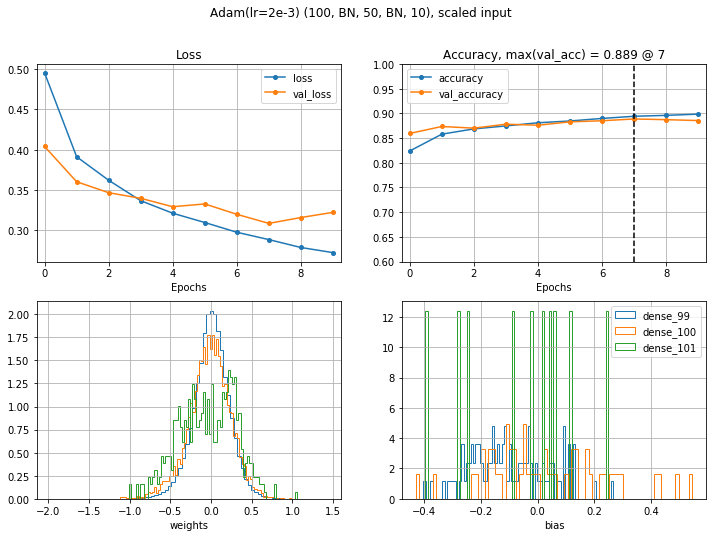

In [135]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle('Adam(lr=2e-3) (100, BN, 50, BN, 10), scaled input');
model.summary()

In [89]:
def batch_gen(iterables, batch_size=32):
    n = len(iterables[0])
    i = 0
    while True:
        start = (i*batch_size) % n
        stop = start + batch_size  
        # NOTE: if stop > n last batch is < batch_size
        yield tuple(arr[start:stop] for arr in iterables)
        i += 1

In [99]:
def lr_one_cycle(batch, lr, max_lr, min_lr, cycle_len):
    half_cycle = cycle_len // 2
    if batch > cycle_len:
        batch = batch % cycle_len
    if batch < half_cycle:
        lr = min_lr + (batch / half_cycle) * (max_lr - min_lr)
    else:
        lr = max_lr - ((batch - half_cycle) / half_cycle) * (max_lr - min_lr)
    return lr

lr_one_cycle.batch = 0

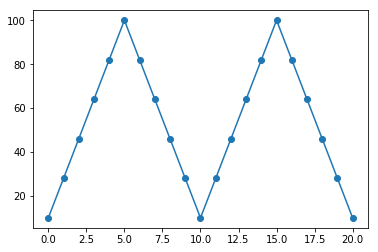

In [100]:
batches = np.arange(21)
lrs = [lr_one_cycle(b, 1, 100, 10, 10) for b in batches]

plt.plot(batches, lrs, '-o')

In [107]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax"),
    ])
optim = keras.optimizers.Adam()
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 256
epochs = 4
cycle_len = np.ceil(y_train.shape[0] / batch_size)
callbacks = [
    LearningRateScheduler(partial(lr_one_cycle, max_lr=1e-3, min_lr=1e-5, cycle_len=cycle_len),
                          divergence=1000),
]

#history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
history = model.fit_generator(batch_gen([X_train_scaled, y_train], batch_size=batch_size),
                    steps_per_epoch= y_train.shape[0] // batch_size, epochs=epochs, workers=0, 
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Epoch 1/4
210/214 [============================>.] - ETA: 0s - loss: 1.0260 - accuracy: 0.6544
End of epoch 0, logs: {'loss': 1.016737627231072, 'accuracy': 0.6573635, 'val_loss': 0.4657956287264824, 'val_accuracy': 0.8392}
214/214 [==============================] - 2s 11ms/step - loss: 1.0167 - accuracy: 0.6574 - val_loss: 0.4658 - val_accuracy: 0.8392
Epoch 2/4
208/214 [============================>.] - ETA: 0s - loss: 0.5039 - accuracy: 0.8231
End of epoch 1, logs: {'loss': 0.5027745079353123, 'accuracy': 0.82332313, 'val_loss': 0.3967339351773262, 'val_accuracy': 0.8626}
214/214 [==============================] - 1s 6ms/step - loss: 0.5028 - accuracy: 0.8233 - val_loss: 0.3967 - val_accuracy: 0.8626
Epoch 3/4
204/214 [===========================>..] - ETA: 0s - loss: 0.4347 - accuracy: 0.8458
End of epoch 2, logs: {'loss': 0.43408416527584653, 'accuracy': 0.8460442, 'val_loss': 0.3668045446276665, 'val_accuracy': 0.8692}
214/214 [==============================] - 1s 6ms/step - loss

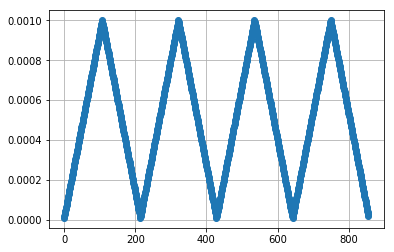

In [108]:
plt.plot(callbacks[0].lr[:], '-o')
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True)

In [109]:
history.history

{'loss': [1.016737627231072,
  0.5027745079353123,
  0.43408416527584653,
  0.40066785667924115],
 'accuracy': [0.6573635, 0.82332313, 0.8460442, 0.8588468],
 'val_loss': [0.4657956287264824,
  0.3967339351773262,
  0.3668045446276665,
  0.34556672126054766],
 'val_accuracy': [0.8392, 0.8626, 0.8692, 0.8732]}

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_73 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


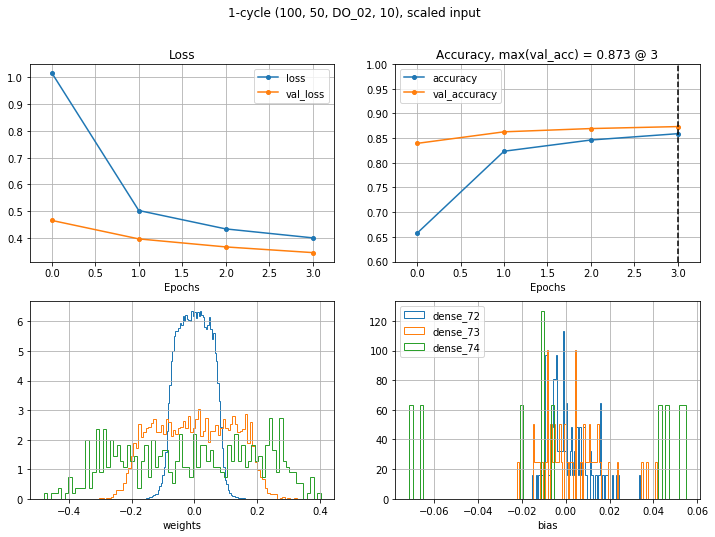

In [110]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
plt.suptitle('1-cycle (100, 50, DO_02, 10), scaled input');
model.summary()

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax"),
    ])
optim = keras.optimizers.Adam(lr=0.0006)
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=3,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 5s 93us/sample - loss: 0.5489 - accuracy: 0.8049 - val_loss: 0.3735 - val_accuracy: 0.8650
Epoch 2/3
55000/55000 [==============================] - 6s 115us/sample - loss: 0.3970 - accuracy: 0.8559 - val_loss: 0.3588 - val_accuracy: 0.8642
Epoch 3/3
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3575 - accuracy: 0.8698 - val_loss: 0.3377 - val_accuracy: 0.8768


<IPython.core.display.Javascript object>


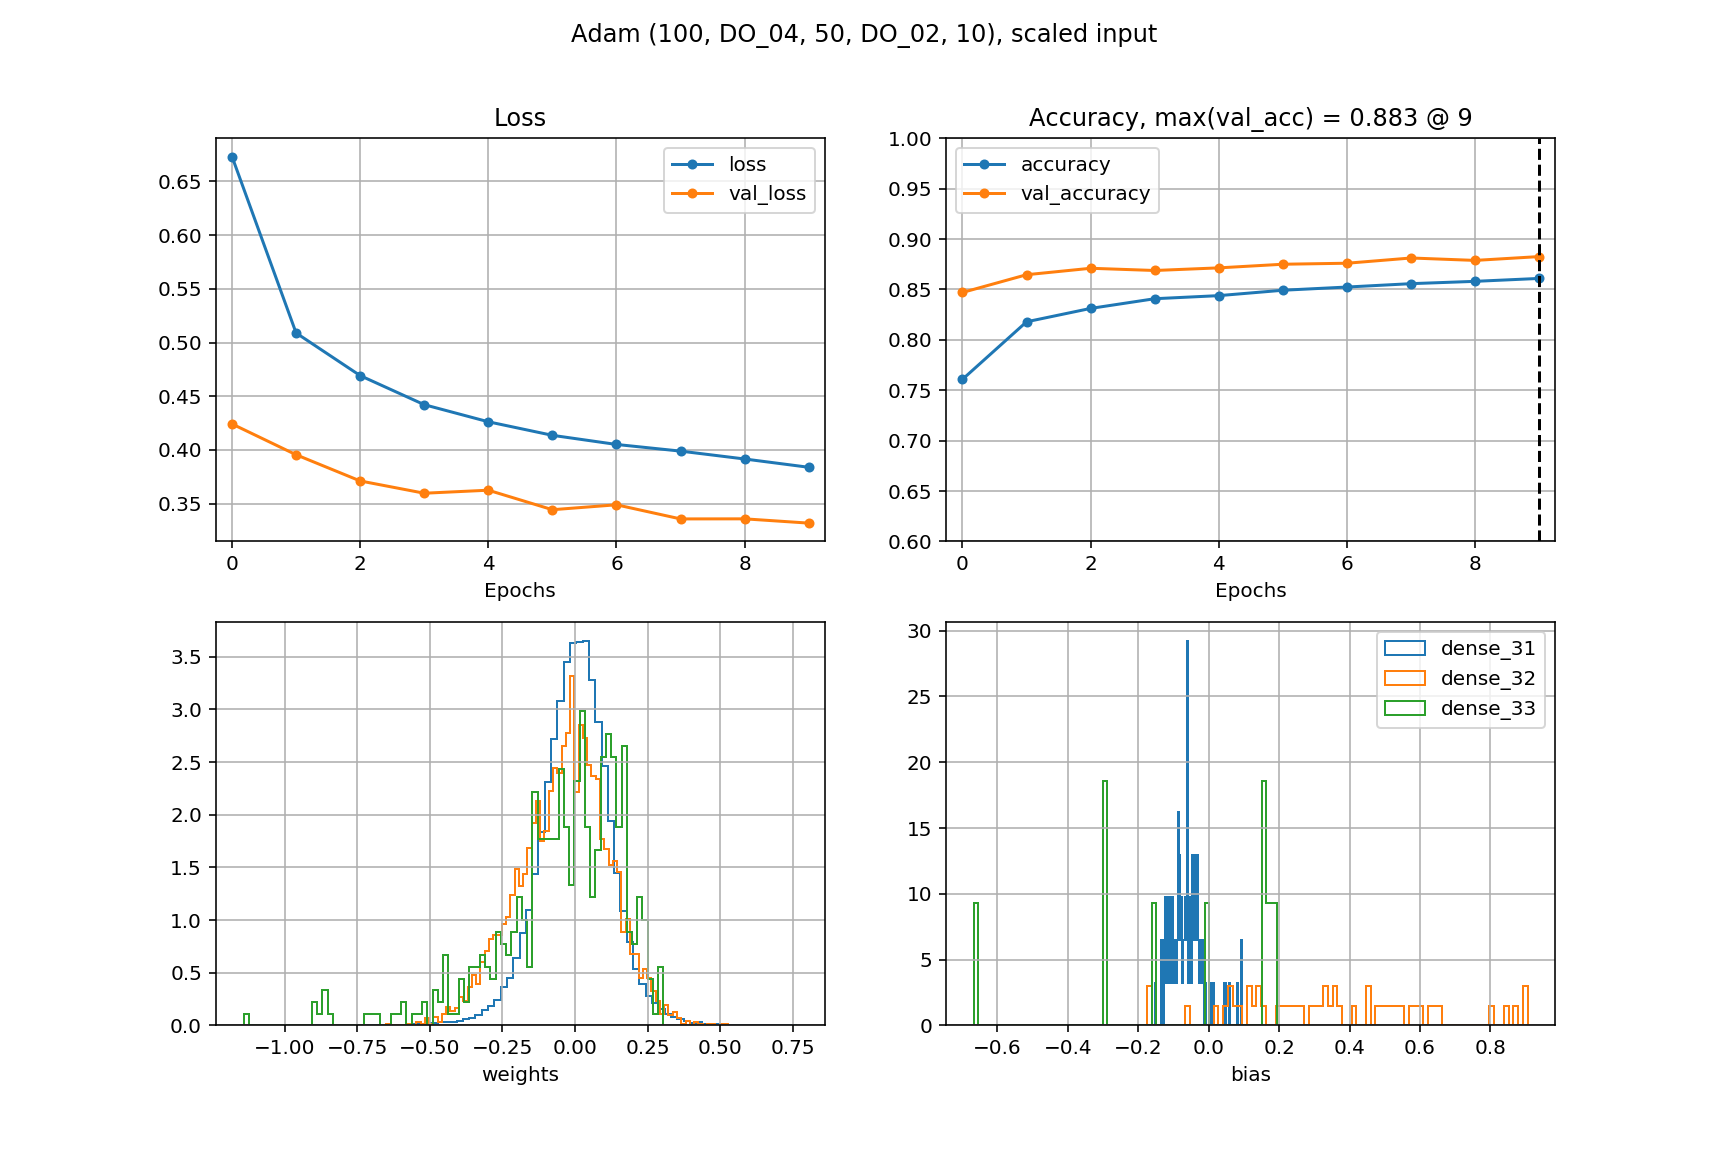

In [58]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, ax=Ax[0])
plot_weights(history, ax=Ax[1])
plt.suptitle('Adam (100, DO_04, 50, DO_02, 10), scaled input');

<IPython.core.display.Javascript object>


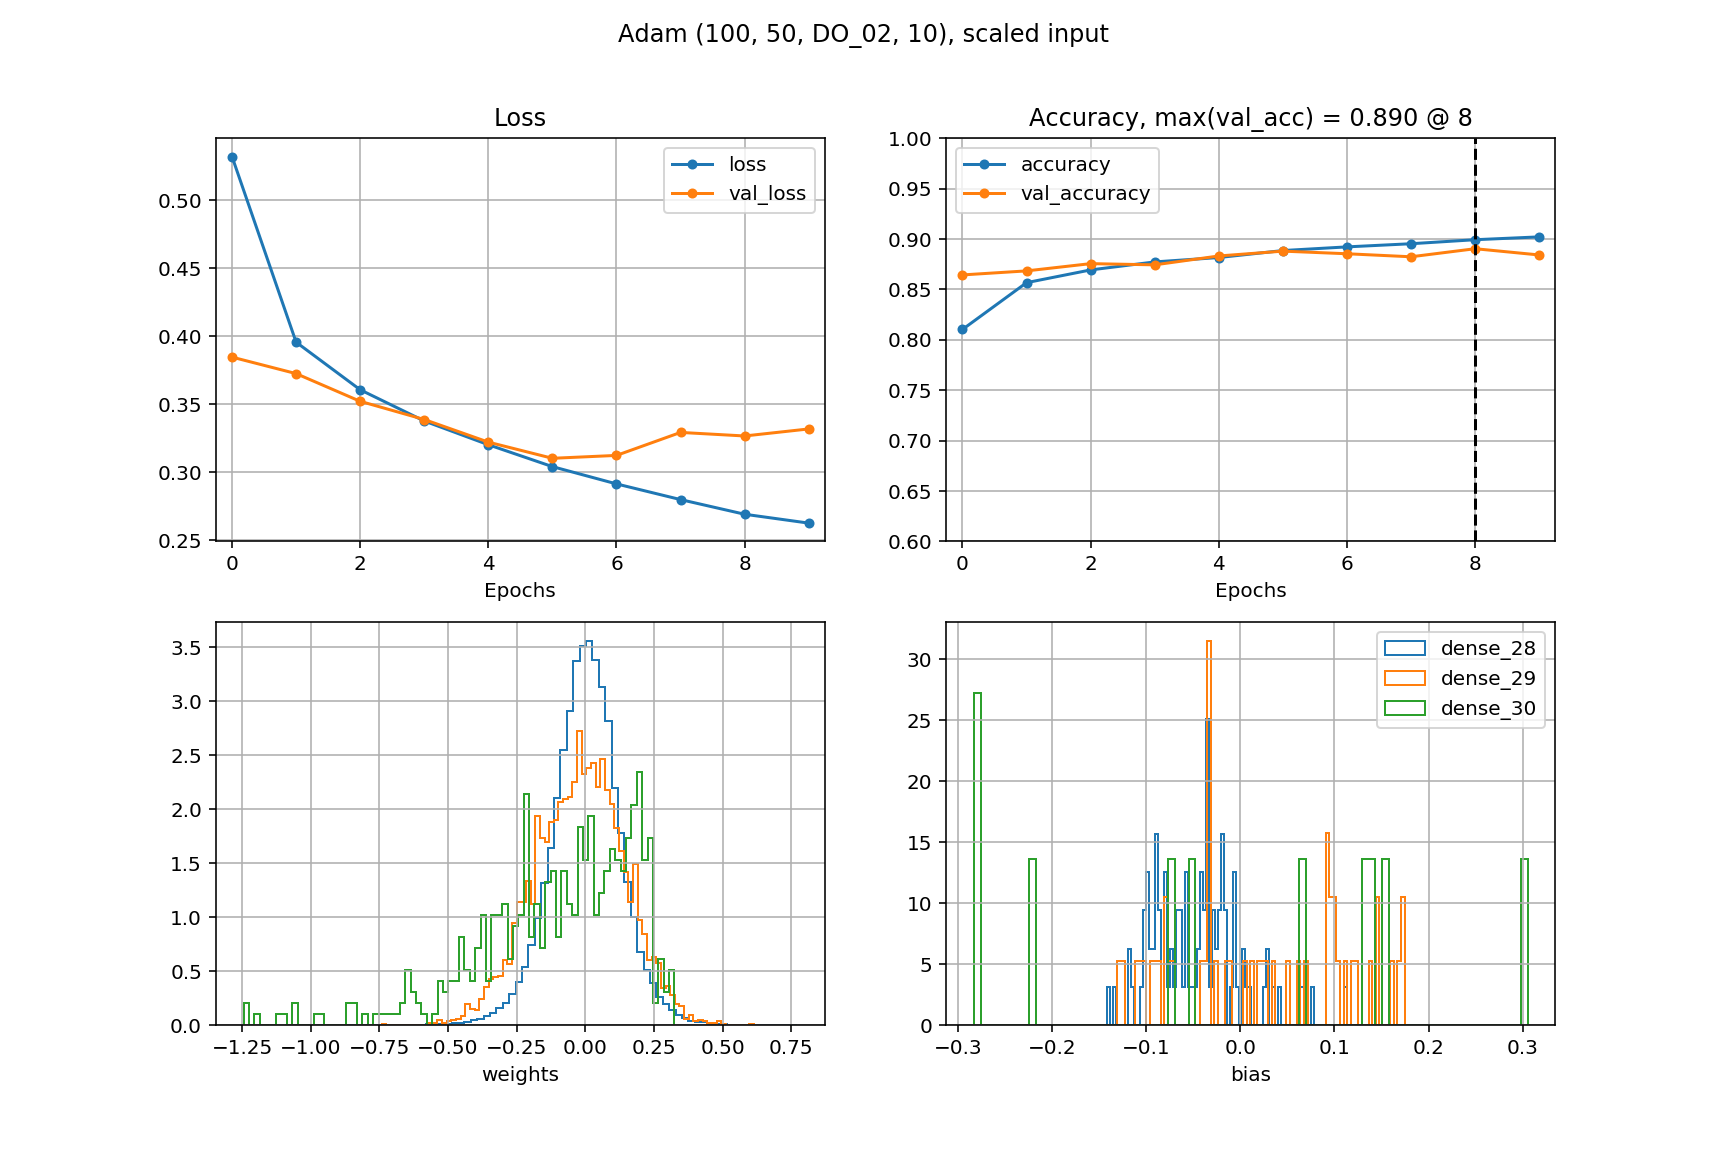

In [55]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, ax=Ax[0])
plot_weights(history, ax=Ax[1])
plt.suptitle('Adam (100, 50, DO_02, 10), scaled input');

<IPython.core.display.Javascript object>


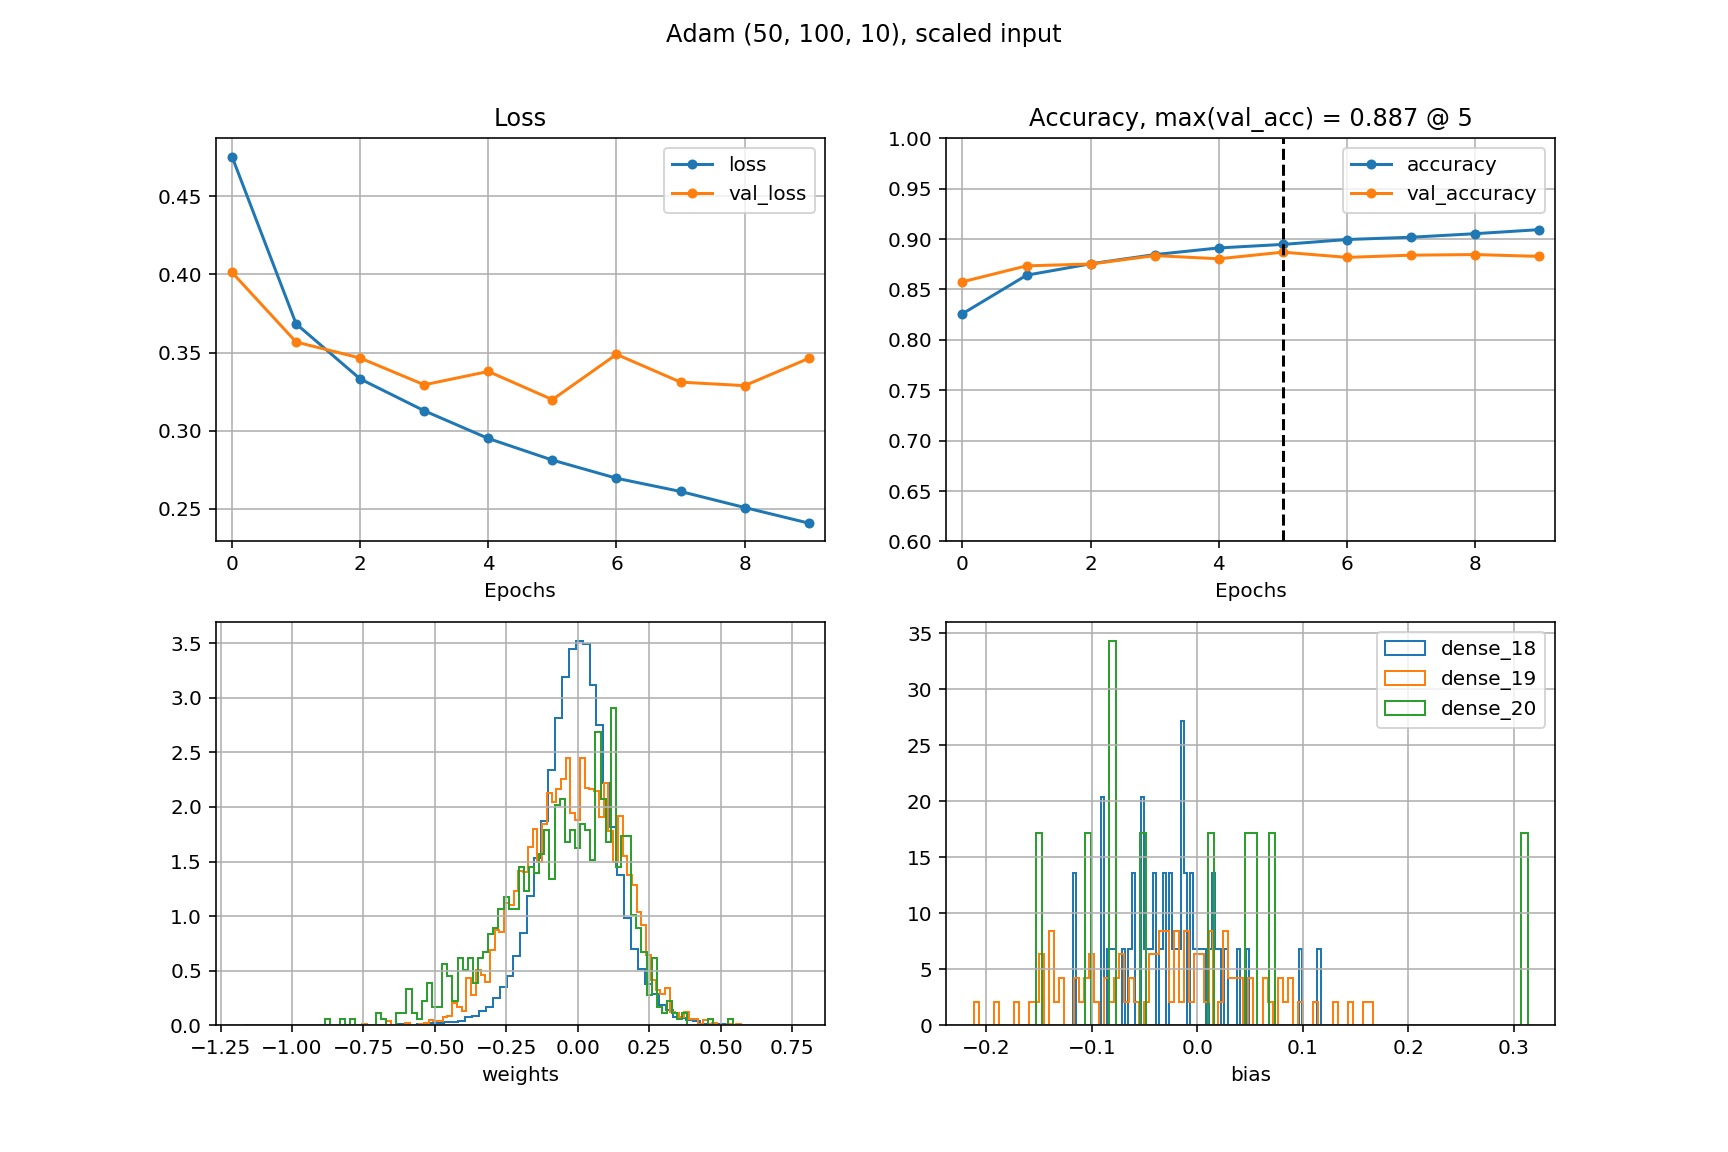

In [38]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, ax=Ax[0])
plot_weights(history, ax=Ax[1])
plt.suptitle('Adam (50, 100, 10), scaled input');

<IPython.core.display.Javascript object>


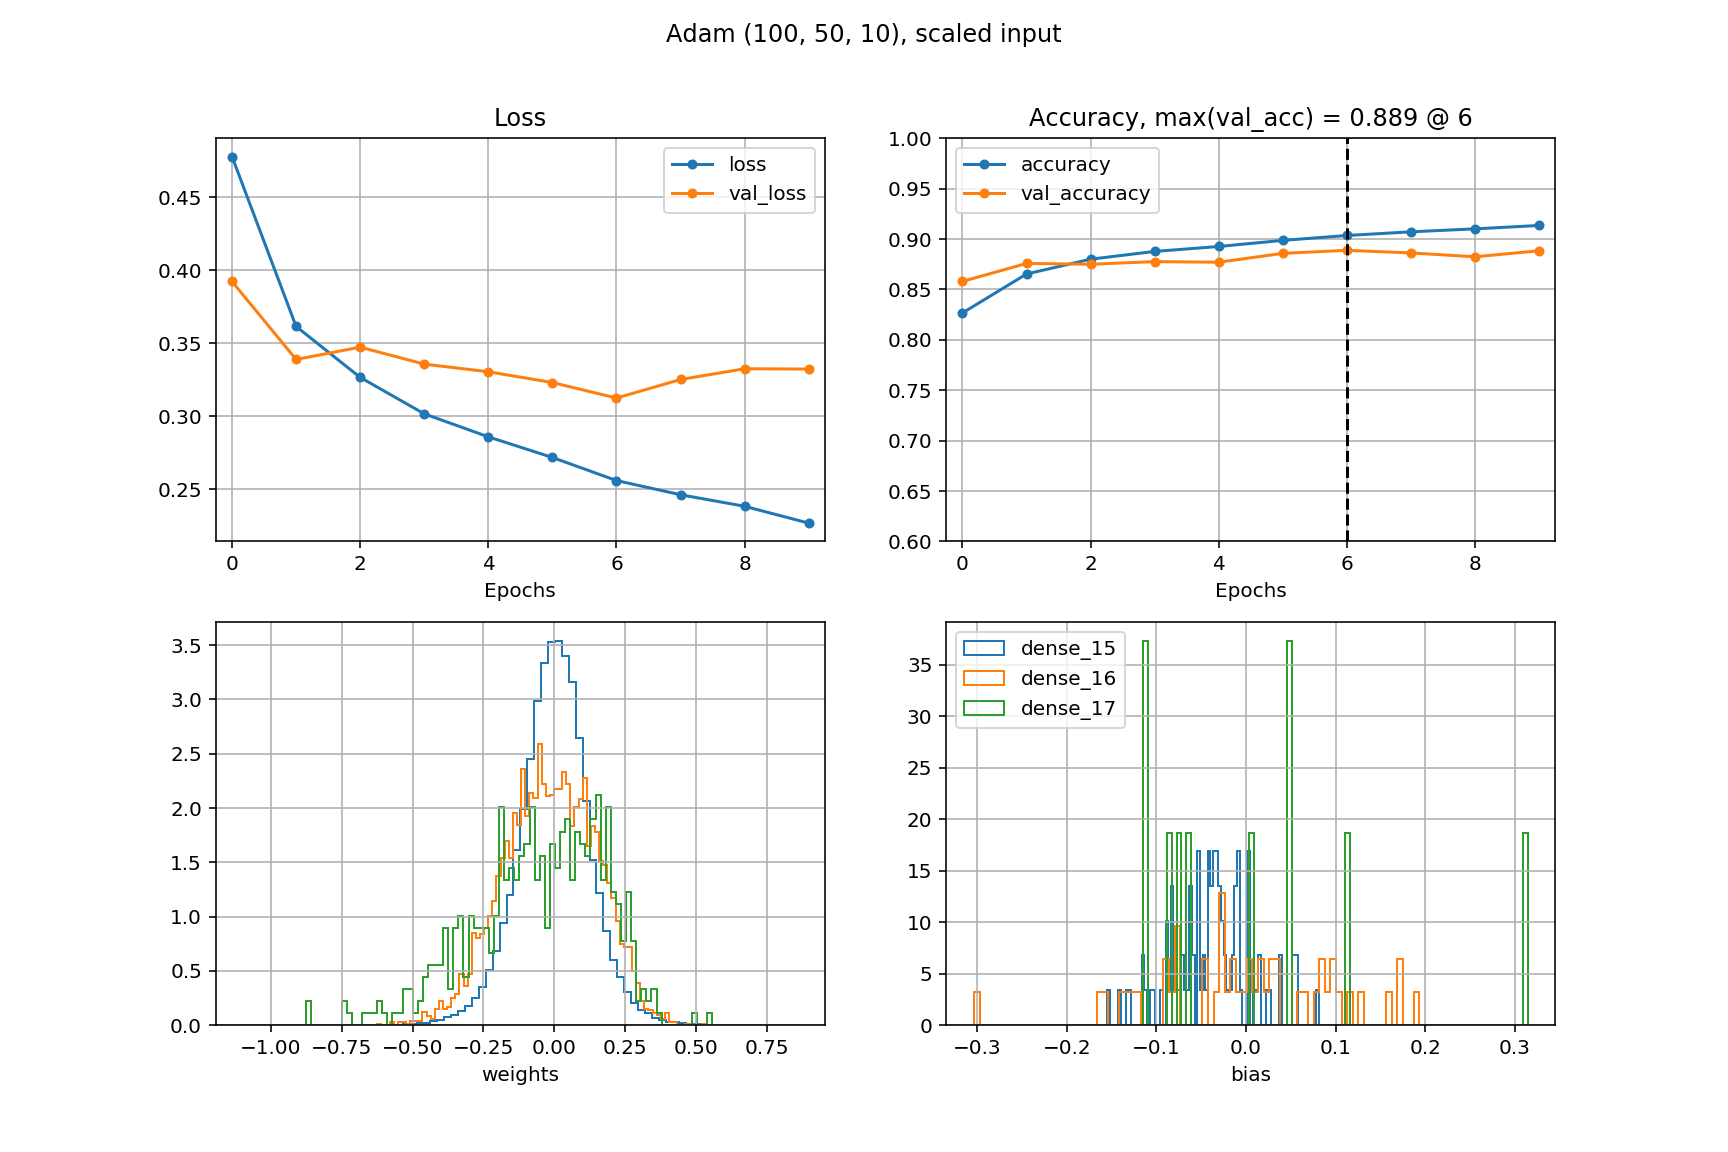

In [34]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, ax=Ax[0])
plot_weights(history, ax=Ax[1])
plt.suptitle('Adam (100, 50, 10), scaled input');

<IPython.core.display.Javascript object>


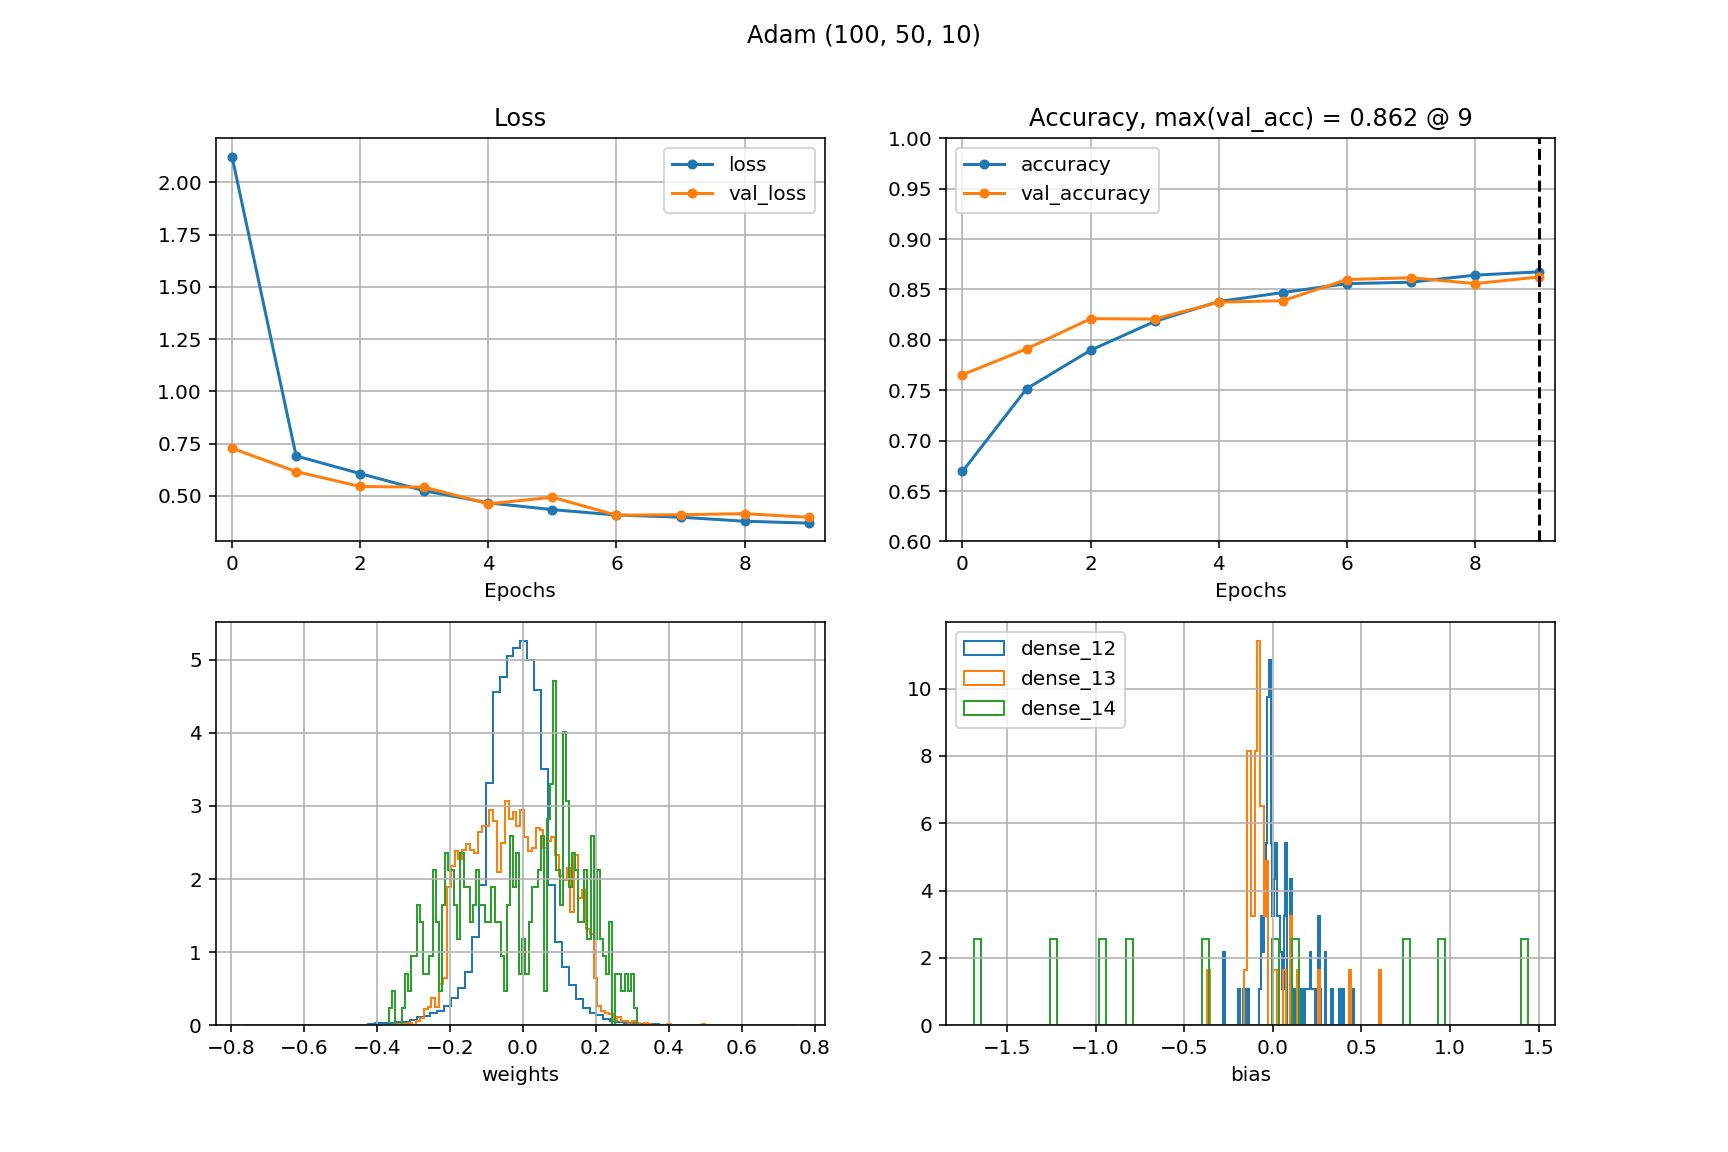

Text(0.5, 0.98, 'Adam (100, 50, 10)')

In [31]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, ax=Ax[0])
plot_weights(history, ax=Ax[1])
plt.suptitle('Adam (100, 50, 10)')

# Visualize Weights

In [165]:
perm = np.random.permutation(X_test.shape[0])

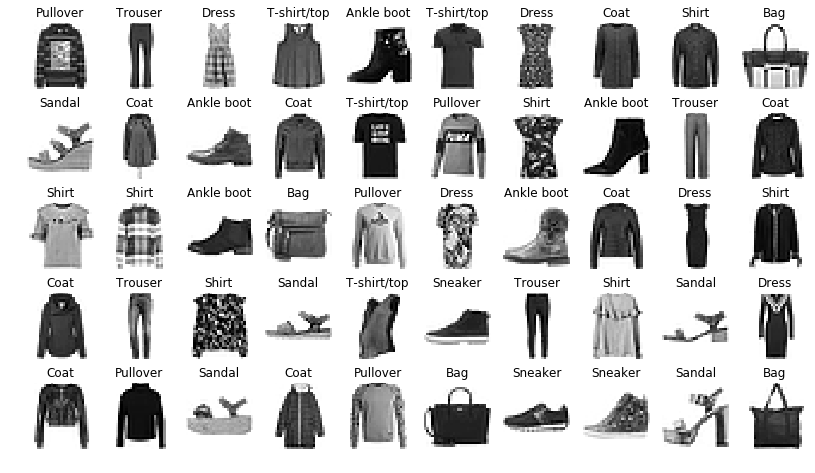

In [166]:
X_test_shuffle = X_test[perm]
y_test_shuffle = y_test[perm]

n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_test_shuffle[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test_shuffle[index]])
plt.show()

In [164]:
kernel_init = "he_normal"
batch_size = 256
epochs = 10
lr = 1e-3
activation="selu"
#α_reg = 1e-4
#mom = 0.8
nesterov = True
model_name = (f'NAdam(lr={lr:.1g}) (100, 50, 10), scaled input, '
              f'batch_size = {batch_size}, {kernel_init}, {activation} '
              #f'α_reg = {α_reg:.1g} N_mom = {mom:.1g}'
             )
HiddenDense = partial(keras.layers.Dense,
                      activation=activation, 
                      kernel_initializer=kernel_init,
                      #kernel_regularizer=keras.regularizers.l2(α_reg)
                     )
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    HiddenDense(100),
    #keras.layers.AlphaDropout(rate=0.2),
    #keras.layers.BatchNormalization(),
    HiddenDense(50),
    #keras.layers.AlphaDropout(rate=0.2),
    #keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax", 
                       kernel_initializer='glorot_uniform',
                       ),
    ],
    name=model_name)
optim = keras.optimizers.Nadam(lr)
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model_name)
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid))

NAdam(lr=0.001) (100, 50, 10), scaled input, batch_size = 256, he_normal, selu 
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 45us/sample - loss: 0.5848 - accuracy: 0.7948 - val_loss: 0.4315 - val_accuracy: 0.8448
Epoch 2/10
55000/55000 [==============================] - 2s 31us/sample - loss: 0.3971 - accuracy: 0.8572 - val_loss: 0.3926 - val_accuracy: 0.8608
Epoch 3/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.3535 - accuracy: 0.8715 - val_loss: 0.3505 - val_accuracy: 0.8768
Epoch 4/10
55000/55000 [==============================] - 2s 30us/sample - loss: 0.3259 - accuracy: 0.8819 - val_loss: 0.3554 - val_accuracy: 0.8718
Epoch 5/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3043 - accuracy: 0.8902 - val_loss: 0.3317 - val_accuracy: 0.8788
Epoch 6/10
55000/55000 [==============================] - 2s 40us/sample - loss: 0.2894 - accuracy: 0.8927 - val_loss: 0.3148 

In [84]:
# we build a new model with the activations of the old model
# this model is truncated after the first layer
amodel = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    HiddenDense(100),
    #keras.layers.Dense(50, activation="relu", 
    #                   weights=model.layers[2].get_weights()),
    #keras.layers.Dropout(rate=0.2),
    #keras.layers.Dense(10, activation="softmax"),
    ])
 

In [85]:
activations = amodel.predict(X_test_shuffle[:120])
activations.shape, (activations > 0).sum() / activations.size

((120, 100), 0.5208333333333334)

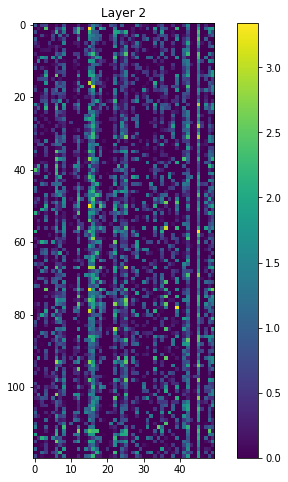

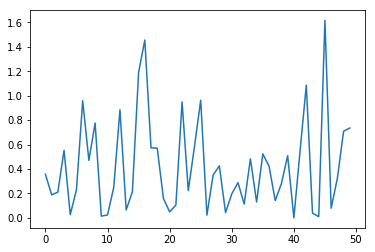

In [64]:
plt.figure(figsize=(8, 8))
plt.imshow(activations)
plt.colorbar()
plt.title('Layer 2');
plt.figure()
plt.plot(activations.mean(axis=0));

In [86]:
activations = amodel.predict(X_test_scaled[:120])
activations.shape, (activations > 0).sum() / activations.size

((120, 100), 0.5185)

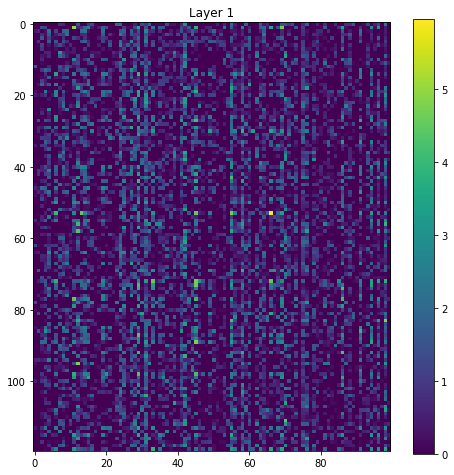

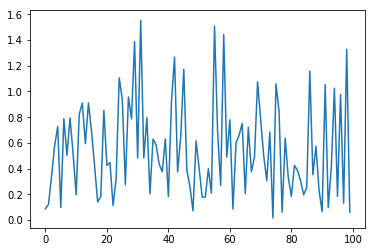

In [87]:
plt.figure(figsize=(8, 8))
plt.imshow(activations)
plt.colorbar()
plt.title('Layer 1');
plt.figure()
plt.plot(activations.mean(axis=0));